###Download Data di Kaggle

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lailabudianti","key":"38fcd3fcf01df7cf365600dfca0458ef"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download cosmos98/twitter-and-reddit-sentimental-analysis-dataset
! unzip twitter-and-reddit-sentimental-analysis-dataset.zip -d tweet

 80% 8.00M/10.0M [00:00<00:00, 78.3MB/s]
100% 10.0M/10.0M [00:00<00:00, 85.5MB/s]
Archive:  twitter-and-reddit-sentimental-analysis-dataset.zip
  inflating: tweet/Reddit_Data.csv   
  inflating: tweet/Twitter_Data.csv  


###Import Library yang akan digunakan

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import plotly.express as px
import seaborn as sns
pd.options.plotting.backend = "plotly"

from sklearn.preprocessing import LabelEncoder
import re   
import nltk  
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, MaxPooling1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras import datasets

from sklearn.metrics import confusion_matrix
from keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


###Eksplorasi Data


In [ ]:
#import dataset
df = pd.read_csv("/content/tweet/Twitter_Data.csv", encoding='latin-1')
df = df[['category','clean_text']]
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head()

,category,clean_text
0,Negative,when modi promised âminimum government maxim...
1,Neutral,talk all the nonsense and continue all the dra...
2,Positive,what did just say vote for modi welcome bjp t...
3,Positive,asking his supporters prefix chowkidar their n...
4,Positive,answer who among these the most powerful world...


In [ ]:
#mengecek dataset yang null
df.isna().sum()

category      7
clean_text    4
dtype: int64

In [ ]:
#menghapus dataset yang kosong
df = df.dropna()

In [ ]:
#mengecek dataset yang null
df.isna().sum()

category      0
clean_text    0
dtype: int64

In [ ]:
#melihat informasi pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   category    162969 non-null  object
 1   clean_text  162969 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [ ]:
#ukuran data set
df.shape

(162969, 2)

In [ ]:
#mengecek dataset beedasarkan variabel category
df.category.value_counts()

Positive    72249
Neutral     55211
Negative    35509
Name: category, dtype: int64

###Visualisasi Data

In [ ]:
fig = px.pie(df, names='category', title ='Pie Chart of Sentiments Category')
fig.show()

###Pre-Processing Data

In [ ]:
#fungsi mengubah text menjadi sequence kata
def tweet_to_words(tweet):
    # mengkonvesi ke huruf kecil
    text = tweet.lower()
    # menghapus non huruf
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # menghapus stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # menerapkan stemming
    words = [PorterStemmer().stem(w) for w in words]
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))


Original tweet -> when modi promised âminimum government maximum governanceâ expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [ ]:
#menerapkan pemrosesan data ke setiap tweet
X = list(map(tweet_to_words, df['clean_text']))

In [ ]:
# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

###Tokenizing $ Pandding

In [ ]:
max_words = 5000
max_len= 60

def tokenize_pad_sequences(text):
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transformai text ke sequence bi. bulat
    X = tokenizer.texts_to_sequences(text)
    # Mengurutkan pad sequence dengan panjang yang sama
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised âminimum government maximum governanceâ expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [ ]:
#saving tokenized data
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

###Membagi data menjadi train dan validation data

In [ ]:
y = pd.get_dummies(df['category'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)

Train Set -> (130375, 60) (130375, 3)
Validation Set -> (32594, 60) (32594, 3)


In [ ]:
# build Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

#compile model
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [ ]:
# callbacks
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")
callbacks = myCallback()

In [ ]:
# Train model

batch_size = 32
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size, 
                    epochs=30, 
                    verbose=1, 
                    callbacks=[callbacks], 
                    validation_steps=30)

Epoch 1/30
4075/4075 [==============================] - 117s 28ms/step - loss: 0.3504 - accuracy: 0.8777 - val_loss: 0.2220 - val_accuracy: 0.9396
Epoch 2/30
4074/4075 [============================>.] - ETA: 0s - loss: 0.1898 - accuracy: 0.9502
The accuracy of the training set and the validation set has reached > 90%!
4075/4075 [==============================] - 117s 29ms/step - loss: 0.1898 - accuracy: 0.9502 - val_loss: 0.1853 - val_accuracy: 0.9458


Pembuatan model diberhentikan denggan menggunakan callback karena accuracy training dan validation sudah melebihi 90%, dengan accuracy adalah:
accuracy training 95.02%
accuracy validation 94.58%

1019/1019 [==============================] - 10s 9ms/step


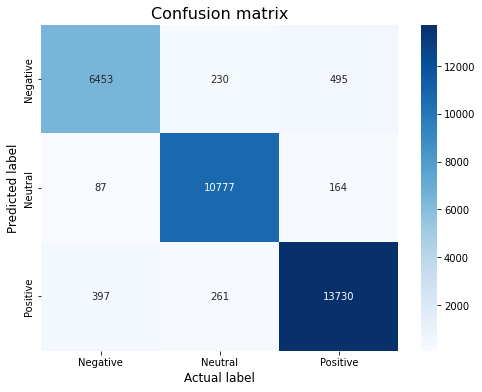

In [ ]:
#Model Confussion Matrix
def plot_confusion_matrix(model, X_, y_test):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_val)
    cm = confusion_matrix(np.argmax(np.array(y_val),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_val, y_val)

In [ ]:
#Model save and load for the prediction
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [ ]:
# Load model
model = load_model('best_model.h5')

def predict_class(text):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    xt = tokenizer.texts_to_sequences(text)
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    yt = model.predict(xt).argmax(axis=1)
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [ ]:
predict_class(['"I hate it when I have to wait for my late friend to arrive'])
predict_class(['The view is artistic'])
predict_class(['He is the most diligent student I have ever met'])

1/1 [==============================] - 0s 40ms/step
The predicted sentiment is Negative
1/1 [==============================] - 0s 127ms/step
The predicted sentiment is Neutral
1/1 [==============================] - 0s 56ms/step
The predicted sentiment is Positive
